<a href="https://colab.research.google.com/github/adityaraj1701/Electricity_Management/blob/main/Consumption_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('/AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

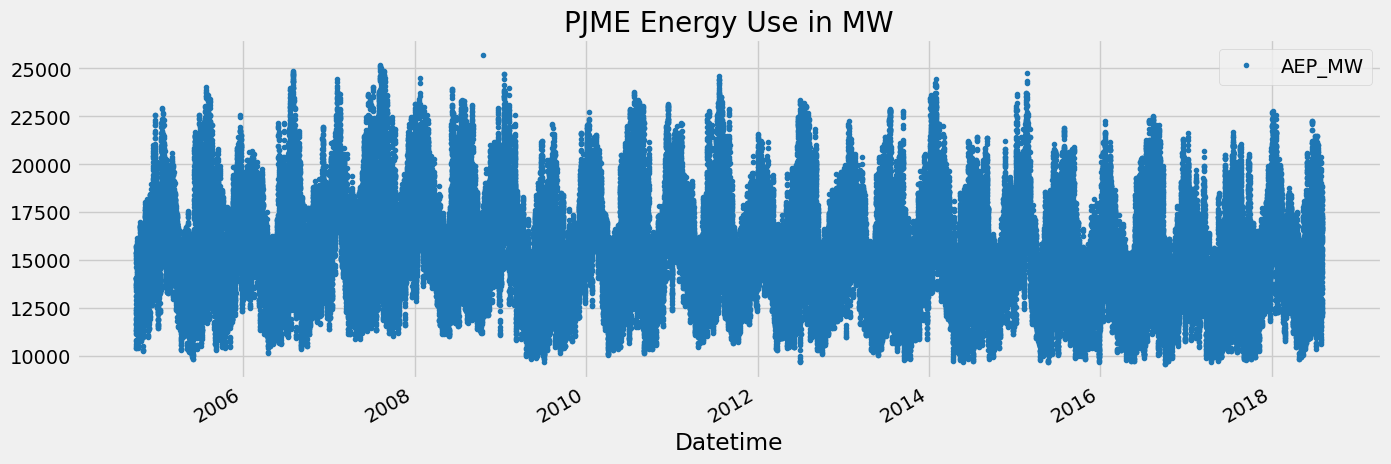

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

<Axes: ylabel='Frequency'>

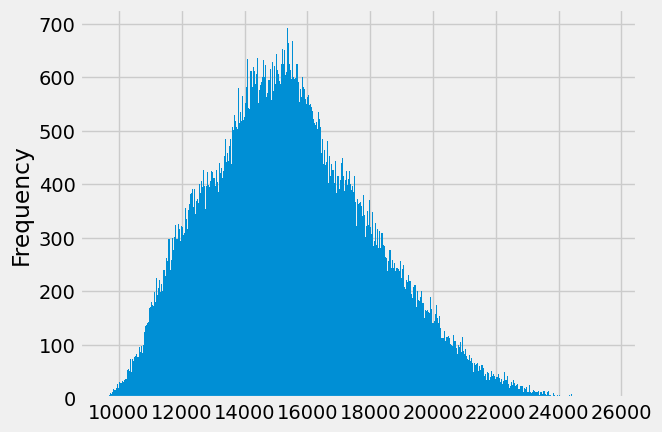

In [6]:
df['AEP_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

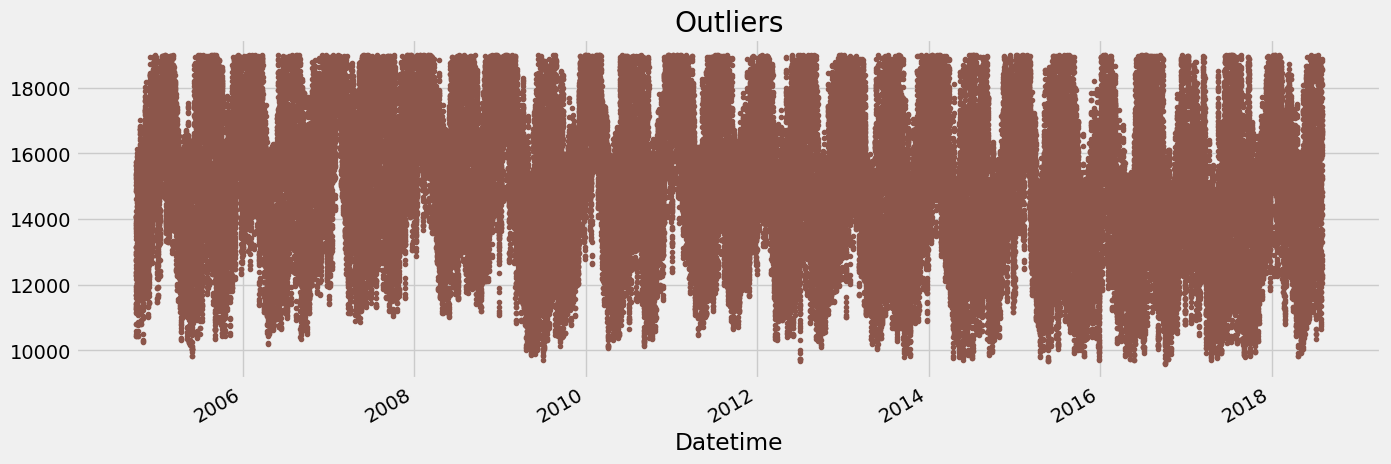

In [7]:
df.query('AEP_MW < 19_000')['AEP_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

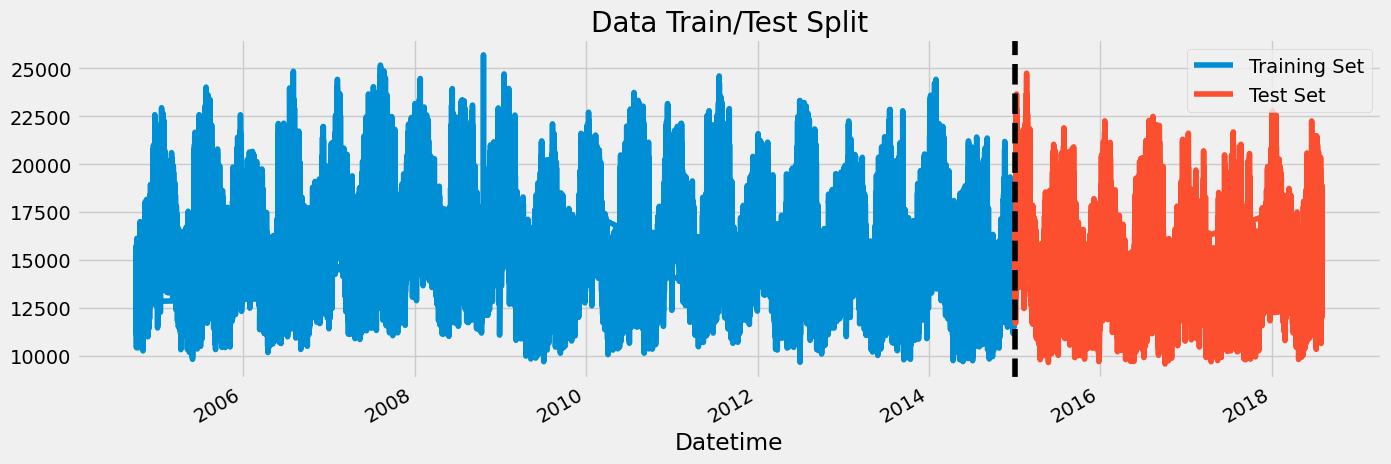

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [9]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

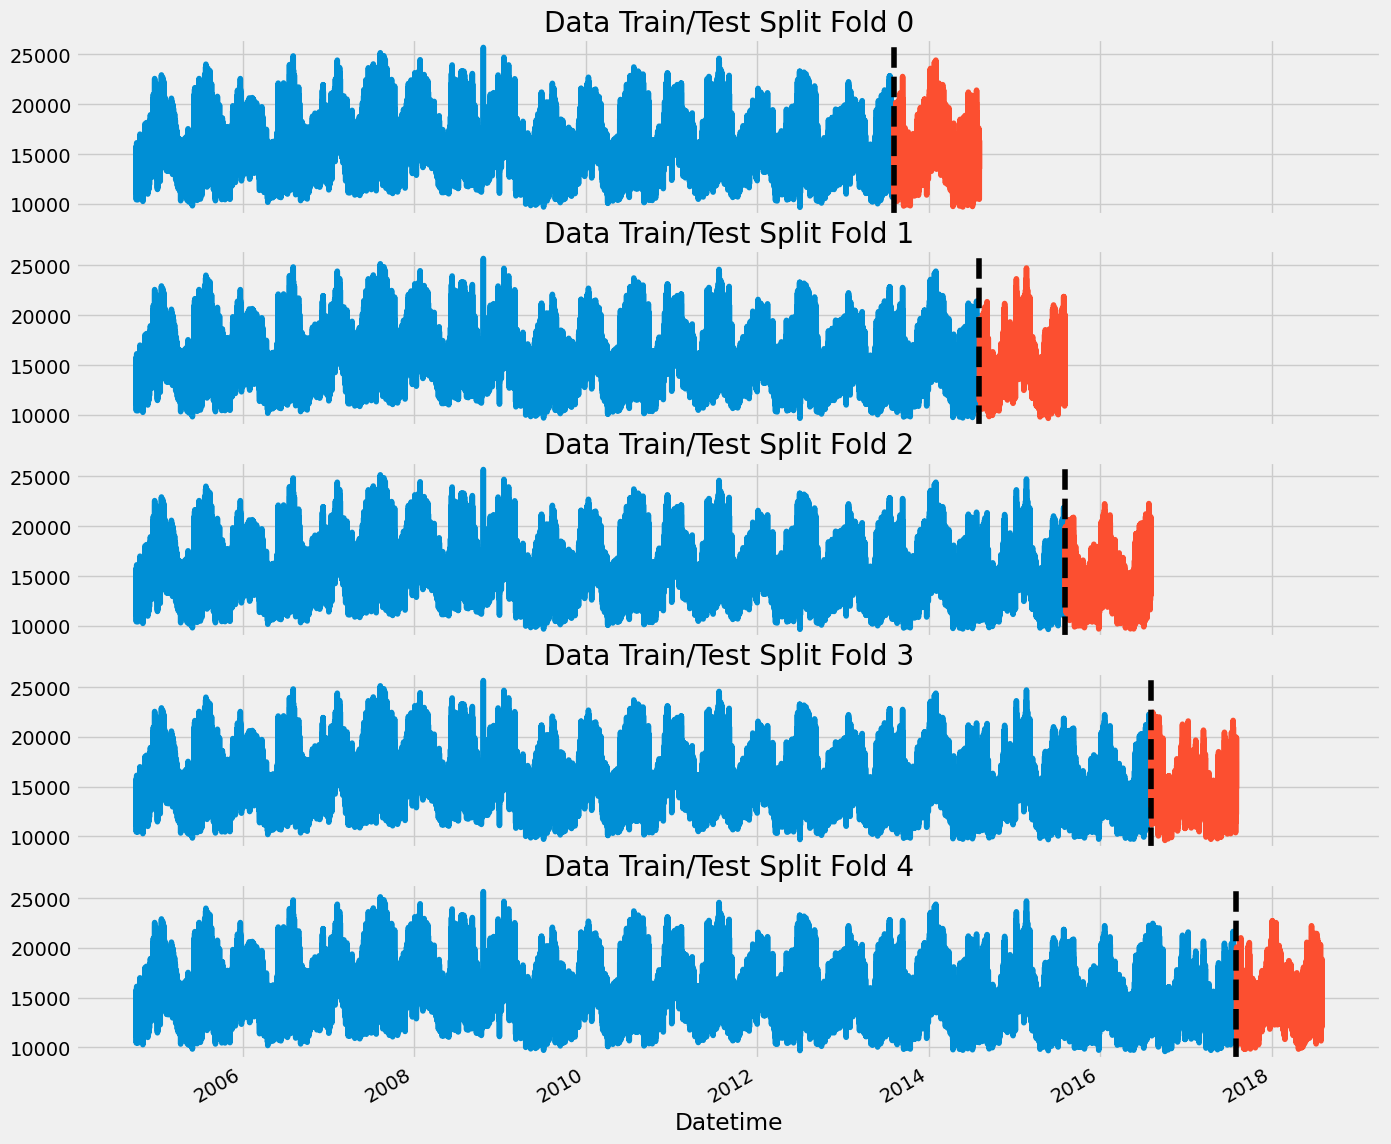

In [11]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AEP_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['AEP_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [12]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [14]:
def add_lags(df):
    target_map = df['AEP_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [15]:
df = add_lags(df)

In [16]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'AEP_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:15898.36633	validation_1-rmse:15264.18323


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:46:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6031.31414	validation_1-rmse:5645.48061
[200]	validation_0-rmse:2654.73567	validation_1-rmse:2429.72487
[300]	validation_0-rmse:1710.33127	validation_1-rmse:1647.64977
[400]	validation_0-rmse:1491.06346	validation_1-rmse:1554.16784
[464]	validation_0-rmse:1447.06260	validation_1-rmse:1556.92999
[0]	validation_0-rmse:15835.43959	validation_1-rmse:15221.95383


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:46:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6007.78651	validation_1-rmse:5715.31503
[200]	validation_0-rmse:2646.11681	validation_1-rmse:2506.80517
[300]	validation_0-rmse:1708.44615	validation_1-rmse:1615.82625
[400]	validation_0-rmse:1501.68843	validation_1-rmse:1454.25308
[500]	validation_0-rmse:1443.65105	validation_1-rmse:1429.72652
[600]	validation_0-rmse:1412.01741	validation_1-rmse:1426.01093
[643]	validation_0-rmse:1402.82849	validation_1-rmse:1425.74479
[0]	validation_0-rmse:15779.22847	validation_1-rmse:14549.82659


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:46:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5985.45144	validation_1-rmse:5101.01305
[200]	validation_0-rmse:2635.24412	validation_1-rmse:2053.29933
[300]	validation_0-rmse:1704.00737	validation_1-rmse:1507.69691
[375]	validation_0-rmse:1527.09283	validation_1-rmse:1521.24100
[0]	validation_0-rmse:15679.42424	validation_1-rmse:14632.67713


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:47:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5950.53232	validation_1-rmse:5462.18027
[200]	validation_0-rmse:2627.60827	validation_1-rmse:2469.11499
[300]	validation_0-rmse:1707.92103	validation_1-rmse:1780.20853
[400]	validation_0-rmse:1505.81318	validation_1-rmse:1667.98889
[500]	validation_0-rmse:1445.78101	validation_1-rmse:1657.60437
[600]	validation_0-rmse:1418.47695	validation_1-rmse:1651.54869
[700]	validation_0-rmse:1399.43030	validation_1-rmse:1648.88357
[729]	validation_0-rmse:1395.59194	validation_1-rmse:1649.59392
[0]	validation_0-rmse:15600.77032	validation_1-rmse:15012.58652


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:47:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5924.87627	validation_1-rmse:5860.41470
[200]	validation_0-rmse:2626.42406	validation_1-rmse:2776.89747
[300]	validation_0-rmse:1717.89176	validation_1-rmse:1901.73680
[400]	validation_0-rmse:1515.18892	validation_1-rmse:1714.38709
[500]	validation_0-rmse:1458.08436	validation_1-rmse:1700.32649
[522]	validation_0-rmse:1450.61482	validation_1-rmse:1703.46147


In [17]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1564.5907
Fold scores:[1553.1311553484215, 1425.550391708293, 1498.5818555443102, 1647.9270157786607, 1697.7629177644824]


In [19]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'AEP_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:15559.01146


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:48:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5908.79365
[200]	validation_0-rmse:2622.44489
[300]	validation_0-rmse:1722.58133
[400]	validation_0-rmse:1523.26596
[499]	validation_0-rmse:1471.05942


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [20]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [21]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [22]:
future_w_features = df_and_future.query('isFuture').copy()

In [23]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

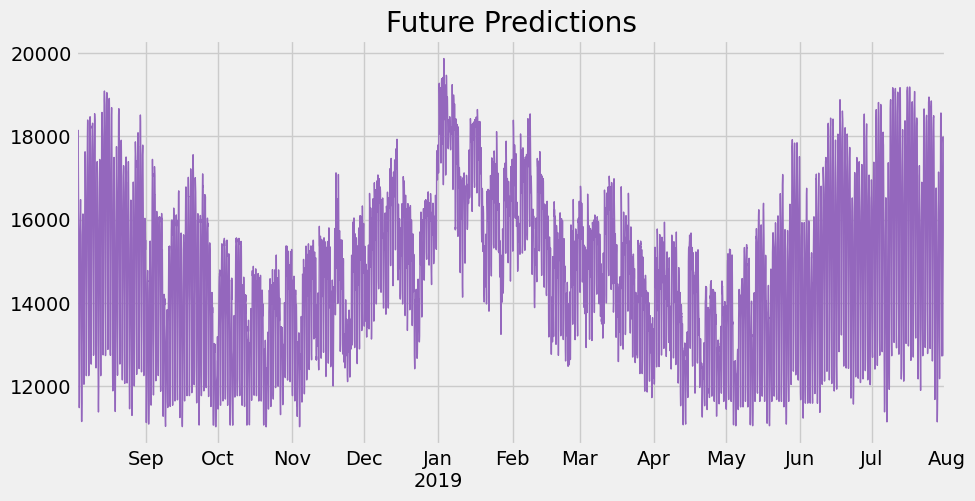

In [24]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [25]:
# Save model
reg.save_model('model.json')

In [26]:
!ls -lh

total 560K
-rw-r--r-- 1 root root 556K Dec  3 10:51 model.json
drwxr-xr-x 1 root root 4.0K Nov 25 19:13 sample_data


<Axes: title={'center': 'Future Predictions'}>

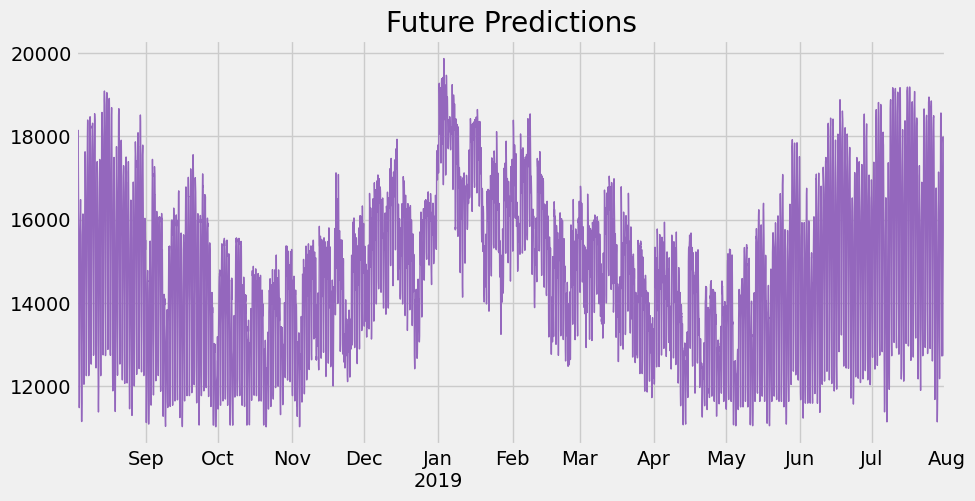

In [27]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')